In [9]:
import os
import datetime
import random
import warnings
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize,LinearSegmentedColormap

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import sklearn.exceptions
from sklearn.utils import class_weight
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D, ZeroPadding2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# import tensorflow_addons as tfa
#finish_sound = "afplay /Users/mehmet/Documents/vs-code/winsquare.mp3"
# !jupyter nbconvert --to html skin-cancer-cnn.ipynb

In [10]:
df=pd.read_csv('dataverse_files/HAM10000_metadata.csv')

df_unique = df.copy()
df_unique.drop_duplicates( subset=['lesion_id'], keep=False, inplace=True)
df_unique=df_unique.drop([ 'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
df_unique = df_unique.reset_index(drop=True)
df=df.drop([ 'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
df_extra = df[~df['image_id'].isin(df_unique['image_id'])] # lesions with multiple images

df_one_of_each = df.copy()
df_extra_unique = df_extra['lesion_id'].unique()
# how to get one image of each lesion_id
for i in df_extra_unique:
    df_one_of_each = df_one_of_each.drop(df_one_of_each[df_one_of_each['lesion_id'] == i].index[1:])

labels = df['dx'].sort_values().unique()

train_df_unique, val_df_unique = train_test_split(df_unique, train_size=0.8, shuffle=True, random_state=123, stratify=df_unique['dx'])

train_df = df[~df['image_id'].isin(val_df_unique['image_id'])] # all train data
train_df_extra = train_df[~train_df['image_id'].isin(train_df_unique['image_id'])] # lesions with multiple images

train_df_one_of_each = train_df.copy()
train_df_extra_unique = train_df_extra['lesion_id'].unique()
# how to get one image of each lesion_id
for i in train_df_extra_unique:
    train_df_one_of_each = train_df_one_of_each.drop(train_df_one_of_each[train_df_one_of_each['lesion_id'] == i].index[1:])

print( 'All data: ',df.shape[0], '| Unique Images:',df_unique.shape[0], '| Data with extras:',df_extra.shape[0])
print('One image from each lesion in data:',df_one_of_each.shape[0])
print('All train data:',train_df.shape[0], '| Unique Train Data:',train_df_unique.shape[0], '| Train data with extras:',train_df_extra.shape[0])
print('One image from each lesion in train data:',train_df_one_of_each.shape[0])
print('Validation data',val_df_unique.shape[0])

All data:  10015 | Unique Images: 5514 | Data with extras: 4501
One image from each lesion in data: 7470
All train data: 8912 | Unique Train Data: 4411 | Train data with extras: 4501
One image from each lesion in train data: 6367
Validation data 1103


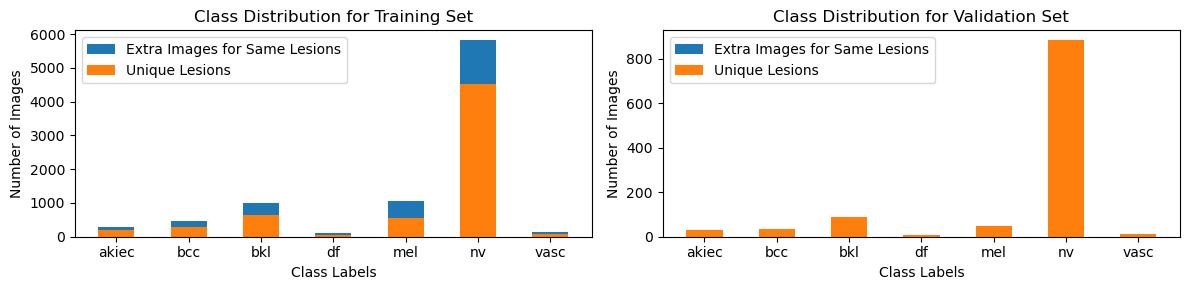

In [11]:
#plotting class distribution for lesion_id and image_id before rebalancing the class
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
bins = np.linspace(0 - .25, 6 + .25, 14)

# Plotting class distribution for training set

ax1.hist(train_df['dx'].sort_values(),bins=bins)
ax1.hist(train_df_one_of_each['dx'].sort_values(),bins=bins)
ax1.set_title("Class Distribution for Training Set")
ax1.set_xlabel('Class Labels')
ax1.set_ylabel('Number of Images')
ax1.legend(['Extra Images for Same Lesions', 'Unique Lesions'])

# Plotting class distribution  for val set
ax2.hist(val_df_unique['dx'].sort_values(),bins=bins)
ax2.hist(val_df_unique['dx'].sort_values(),bins=bins)
ax2.set_title("Class Distribution for Validation Set")
ax2.set_xlabel('Class Labels')
ax2.set_ylabel('Number of Images')
ax2.legend(['Extra Images for Same Lesions', 'Unique Lesions'])

plt.tight_layout()
#plt.savefig('class_distribution.png')
plt.show()

In [12]:
def random_augment(image):
    tf.random.set_seed(123)
    # Randomly applied horizontal flip - reasonable for skin images
    image = tf.image.random_flip_left_right(image)
    
    # Random brightness - simulate different lighting conditions
    image = tf.image.random_brightness(image, max_delta=0.1)
    
    # Random contrast - simulate variations in camera quality and settings
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random rotation - lesions can be oriented in any direction
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Gaussian blur - simulate slight focus variations
    # image = tfa.image.gaussian_filter2d(image, filter_shape=(3, 3), sigma=1.0)
    
    return image

In [13]:
def augmentention_on_dataset(df, df_unique, dataset_type, images_directory, max_sample, min_sample):
    if not os.path.exists(images_directory+'_augmented'):
        os.mkdir(images_directory+'_augmented') 
        
    if df.shape == df_unique.shape:
        print('For Validation Set')
        for label in df['dx'].unique():
            df_label = df[df['dx'] == label]
            df_unique_label = df_unique[df_unique['dx'] == label]
        
            #If in the label is more than n images we delete all duplicates and sometimes part of random unique imagas
            if(len(df_label) > max_sample):
                df = pd.concat([df[df['dx'] != label], df_unique[df_unique['dx'] == label]])
                df_label = df[df['dx'] == label]
                drop_indices = np.random.choice(df[df['dx'] == label].index, len(df_label) - max_sample, replace=False)
                df = pd.concat([df[df['dx'] != label], df_label.drop(drop_indices)])
            
            #If in the label is less than n images we randomly choose unique images for augmentation
            if(len(df_label) < min_sample):
                selected_indices = np.random.choice(df_unique_label.index, min_sample - len(df_label), replace=True)
                df_to_add = df_unique_label.loc[selected_indices]
                df_to_add['image_id'] = df_to_add['image_id'] + '-' + dataset_type + (df_to_add.groupby('image_id').cumcount() + 1).astype(str)
                df = pd.concat([df, df_to_add])
            
        for j in df[df['image_id'].str.len() == 12]['image_id'].values:
            # copy image without change to augmented folder
            shutil.copy(images_directory + '/'+j+'.jpg', images_directory + '_augmented'+ '/'+j+'.jpg')
            
        for i in df[df['image_id'].str.len() > 12]['image_id'].values:
            image = tf.io.read_file(os.path.join(images_directory, i.split('-')[0] + '.jpg'))
            image = tf.image.decode_jpeg(image, channels=3)
        
            # Apply augmentations
            augmented_image = random_augment(image)
        
            # Convert back to image format and save the augmented image
            augmented_image = tf.cast(augmented_image, tf.uint8)
            augmented_image = tf.image.encode_jpeg(augmented_image)
            tf.io.write_file(os.path.join(images_directory+'_augmented', i + '.jpg'), augmented_image)
        
        df['image_id'] = df['image_id'].astype(str) + '.jpg'
        df_shuffled = df.copy().sample(frac=1, random_state=123).reset_index(drop=True)
        
    else:
        print('For Training Set')

        df_extra = df[~df['image_id'].isin(df_unique['image_id'])]
        df_extra_unique = df_extra.copy()
        df_extra_unique_list = df_extra['lesion_id'].unique()
        # how to get one image of each lesion_id
        for i in df_extra_unique_list:
            df_extra_unique = df_extra_unique.drop(df_extra_unique[df_extra_unique['lesion_id'] == i].index[1:])
        df_extra_extra = df_extra[~df_extra['image_id'].isin(df_extra_unique['image_id'])]
        
        for label in df['dx'].unique():
            df_label = df[df['dx'] == label]
            df_unique_label = df_unique[df_unique['dx'] == label]
            df_extra_label = df_extra[df_extra['dx'] == label]
            df_extra_unique_label = df_extra_unique[df_extra_unique['dx'] == label]
            df_extra_extra_label = df_extra_extra[df_extra_extra['dx'] == label]  
              
            # If there are more than n images in the label, we delete all duplicates and sometimes part of random unique images
            if(len(df_label) > max_sample):
                delete = len(df_label) - max_sample
                if len(df_extra_extra_label) > delete:                  
                    drop_indices = np.random.choice(df_extra_extra[df_extra_extra['dx'] == label].index, delete, replace=False)
                    df = pd.concat([df[df['dx'] != label], df_extra_extra_label.drop(drop_indices), df_unique[df_unique['dx'] == label], df_extra_unique[df_extra_unique['dx'] == label]])
                else:
                    if len(df_extra_label) > delete:
                        drop2 = delete - len(df_extra_extra_label)
                        drop_indices2 = np.random.choice(df_extra_unique[df_extra_unique['dx'] == label].index, drop2, replace=False)
                        df = pd.concat([df[df['dx'] != label], df_extra_unique_label.drop(drop_indices2), df_unique[df_unique['dx'] == label]])
                    else:
                        drop2 = delete - len(df_extra_label)  
                        drop_indices2 = np.random.choice(df_unique[df_unique['dx'] == label].index, drop2, replace=False)
                        df = pd.concat([df[df['dx'] != label], df_unique_label.drop(drop_indices2)])
                        
            # If there are less than n images in the label, we randomly choose unique images for augmentation
            if(len(df_label) < min_sample):
                selected_indices = np.random.choice(df_unique_label.index, min_sample - len(df_label), replace=True)
                df_to_add = df_unique_label.loc[selected_indices]
                df_to_add['image_id'] = df_to_add['image_id'] + '-' + dataset_type + (df_to_add.groupby('image_id').cumcount() + 1).astype(str)
                df = pd.concat([df, df_to_add])
            
        for j in df[df['image_id'].str.len() == 12]['image_id'].values:
            # copy image without change to augmented folder
            shutil.copy(images_directory + '/'+j+'.jpg', images_directory + '_augmented'+ '/'+j+'.jpg')
            
        for i in df[df['image_id'].str.len() > 12]['image_id'].values:
            image = tf.io.read_file(os.path.join(images_directory, i.split('-')[0] + '.jpg'))
            image = tf.image.decode_jpeg(image, channels=3)
        
            # Apply augmentations
            augmented_image = random_augment(image)
        
            # Convert back to image format and save the augmented image
            augmented_image = tf.cast(augmented_image, tf.uint8)
            augmented_image = tf.image.encode_jpeg(augmented_image)
            tf.io.write_file(os.path.join(images_directory+'_augmented', i + '.jpg'), augmented_image)
            
        df['image_id'] = df['image_id'].astype(str) + '.jpg'
        df_shuffled = df.copy().sample(frac=1, random_state=123).reset_index(drop=True)
        #df_shuffled.to_csv(f'dataverse_files/HAM10000_metadata_augmented_' + dataset_type +'.csv', index=False)
        
        
    return df_shuffled

In [14]:
print_list = 'All', 'Unique', 'One of Each', 'Val all unique'
print(print_list)
for label in labels:
    list1 = len(train_df[train_df['dx'] == label]), len(train_df_unique[train_df_unique['dx'] == label]), len(train_df_one_of_each[train_df_one_of_each['dx'] == label]), len(val_df_unique[val_df_unique['dx'] == label])
    space = ' '
    
    print(label,(5-len(label))*space ,list1)
train_df.shape[0], train_df_unique.shape[0], train_df_one_of_each.shape[0], val_df_unique.shape[0]

('All', 'Unique', 'One of Each', 'Val all unique')
akiec  (297, 121, 198, 30)
bcc    (479, 140, 292, 35)
bkl    (1011, 352, 639, 88)
df     (107, 31, 65, 8)
mel    (1067, 184, 568, 46)
nv     (5822, 3532, 4520, 883)
vasc   (129, 51, 85, 13)


(8912, 4411, 6367, 1103)

In [15]:
input_path = "dataverse_files/HAM10000_images_pca"

train_all_df = augmentention_on_dataset(train_df, train_df_unique, 'train_df', input_path, 1350, 720)
val_all_df = augmentention_on_dataset(val_df_unique, val_df_unique, 'val_df', input_path, 150, 80)
train_all_df.to_csv(f'dataverse_files/HAM10000_metadata_augmented_' + 'train' +'.csv', index=False)
val_all_df.to_csv(f'dataverse_files/HAM10000_metadata_augmented_' + 'val' +'.csv', index=False)

train_all_df = pd.read_csv('dataverse_files/HAM10000_metadata_augmented_train.csv')
val_all_df = pd.read_csv('dataverse_files/HAM10000_metadata_augmented_val.csv')


For Training Set
For Validation Set


In [16]:
# Extracting All Image - Augmented Images - Unique Images - One of Each Lesion Images

train_df_copy = train_df.copy()
train_df_copy['image_id'] = train_df_copy['image_id'].astype(str) + '.jpg'

train_augmented_df = train_all_df[~train_all_df['image_id'].isin(train_df_copy['image_id'])]
train_unique = train_all_df[~train_all_df['image_id'].isin(train_augmented_df['image_id'])]

df_one_of_each_augmented = train_unique.copy()
df_extra_unique = df_extra['lesion_id'].unique()
# how to get one image of each lesion_id
for i in df_extra_unique:
    df_one_of_each_augmented = df_one_of_each_augmented.drop(df_one_of_each_augmented[df_one_of_each_augmented['lesion_id'] == i].index[1:])

list11 = train_all_df.shape[0], train_augmented_df.shape[0], train_unique.shape[0], df_one_of_each_augmented.shape[0]


val_df_unique_copy = val_df_unique.copy()
val_df_unique_copy['image_id'] = val_df_unique_copy['image_id'].astype(str) + '.jpg'
val_augmented_df = val_all_df[~val_all_df['image_id'].isin(val_df_unique_copy['image_id'])]
val_unique = val_all_df[~val_all_df['image_id'].isin(val_augmented_df['image_id'])]
list12 = val_all_df.shape[0], val_augmented_df.shape[0], val_unique.shape[0]
list13 = 'all', 'augmented', 'unique', 'one of each'
print('Training Set')
print(list13)
print(list11)

for label in labels:
    list1 = len(train_all_df[train_all_df['dx'] == label]), len(train_augmented_df[train_augmented_df['dx'] == label]), len(train_unique[train_unique['dx'] == label]), len(df_one_of_each_augmented[df_one_of_each_augmented['dx'] == label])
    space = ' '
    print(label,(5-len(label))*space ,list1)
print('\n')
print('Validation Set')
list14 = 'all', 'augmented', 'unique'
print(list14)
print(list12)
for label in labels:
    list2 = len(val_all_df[val_all_df['dx'] == label]),len(val_augmented_df[val_augmented_df['dx'] == label]), len(val_unique[val_unique['dx'] == label])
    space = ' '
    print(label,(5-len(label))*space , list2)

Training Set
('all', 'augmented', 'unique', 'one of each')
(6308, 1868, 4440, 3197)
akiec  (720, 423, 297, 198)
bcc    (720, 241, 479, 292)
bkl    (1011, 0, 1011, 639)
df     (720, 613, 107, 65)
mel    (1067, 0, 1067, 568)
nv     (1350, 0, 1350, 1350)
vasc   (720, 591, 129, 85)


Validation Set
('all', 'augmented', 'unique')
(638, 268, 370)
akiec  (80, 50, 30)
bcc    (80, 45, 35)
bkl    (88, 0, 88)
df     (80, 72, 8)
mel    (80, 34, 46)
nv     (150, 0, 150)
vasc   (80, 67, 13)


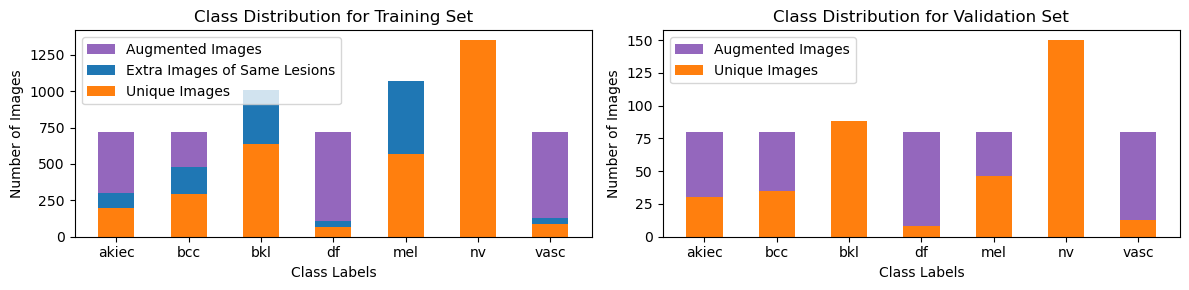

In [17]:
# Plotting class distribution for lesion_id and image_id after rebalancing the class
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
bins = np.linspace(0 - .25, 6 + .25, 14)

# Plotting class distribution for training set
train_hist1 = ax1.hist(train_all_df['dx'].sort_values(), bins=bins, color='tab:purple')
train_hist2 = ax1.hist(train_unique['dx'].sort_values(), bins=bins, color='tab:blue')
train_hist3 = ax1.hist(df_one_of_each_augmented['dx'].sort_values(), bins=bins, color='tab:orange')
ax1.set_title("Class Distribution for Training Set")
ax1.set_xlabel('Class Labels')
ax1.set_ylabel('Number of Images')

# Plotting class distribution for validation set
val_hist1 = ax2.hist(val_all_df['dx'].sort_values(), bins=bins, color='tab:purple')
val_hist2 = ax2.hist(val_unique['dx'].sort_values(), bins=bins, color='tab:orange')
ax2.set_title("Class Distribution for Validation Set")
ax2.set_xlabel('Class Labels')
ax2.set_ylabel('Number of Images')

# Set legend colors
ax1.legend([train_hist1[2][0], train_hist2[2][0], train_hist3[2][0]], ['Augmented Images', 'Extra Images of Same Lesions', 'Unique Images'])
ax2.legend([val_hist1[2][0], val_hist2[2][0]], ['Augmented Images', 'Unique Images'])

plt.tight_layout()
#plt.savefig('class_distribution_augmented.png')
plt.show()